In [229]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import functools 
import operator

from sklearn import utils

import datetime
import csv
#import nltk
from sklearn.preprocessing import MultiLabelBinarizer


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split

In [230]:
# path for the csv files
DATA_PATH = os.path.join(os.getcwd(), 'data')

# loading data to pandas dataframe
def load_data(file_name): 
    file_path = os.path.join(DATA_PATH, file_name) 
    return pd.read_csv(file_path, parse_dates = ['purchase_date', 'release_date'])

def extract_dateinfo(df, col_name, datetype='year'):
    '''
    extract date type into specific year, month, date
    '''
    date_type = {'year': df[col_name].dt.year, 'month': df[col_name].dt.month, 'day': df[col_name].dt.day}[datetype]
    
    df.loc[:, col_name+'_'+ datetype] = date_type
    return df

#Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    for col in features:
        # calculating interquartile range
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR  
        
        # get the indices of outliers for feature col
        outliers_in_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the indices to oulier_indices
        outlier_indices.extend(outliers_in_col)
    
    outlier_indices = Counter(outlier_indices)
    result = list(k for k, v in outlier_indices.items() if v > n)
    
    return result

def process_string(string):
    '''
    split strings in categories/tags/genres 
    make all the words in lowercase
    remove all '-'
    '''
    string = string.lower()
    punctuation = "-"
    
    string = ''.join('' if c.isalpha()==False else c for c in string)
    
    return string

def get_cate_type_data(df, column_name):
    cate_list = list(df[column_name].apply(lambda x: set(x)))
    cate_list = set(functools.reduce(operator.iconcat, cate_list, []))
    return cate_list
    
def count_cate_game(df):
    df_copy = df.copy()
    df_copy = df_copy.transpose()
    return df_copy.astype(bool).sum(axis=1)

def plot_heat_map(corr, figsize=(30, 9)):
    plt.figure(figsize=figsize)
    g = sns.heatmap(corr, annot=True, cmap = "coolwarm")


In [231]:
train_set = load_data('train.csv')
test_set = load_data('test.csv')

In [232]:
# Drop outliers from training data
outliers_to_drop = detect_outliers(train_set, 1 ,['price', 'total_positive_reviews', 'total_negative_reviews'])
train_set.loc[outliers_to_drop]
train_set = train_set.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

# merge training data and testing data 
game_info =  pd.concat(objs=[train_set, test_set], axis=0, sort=False).reset_index(drop=True)

#fill missing purchase date with the most frequent value in purchase_date column
game_info['purchase_date'].fillna(game_info['purchase_date'].mode()[0], inplace=True)


#fille missing number of positive_reviews and negative_reviews with zeros
game_info['total_positive_reviews'].fillna(0.0, inplace=True)
game_info['total_negative_reviews'].fillna(0.0, inplace=True)

#print(game_info.isnull().any().any())
#game_info['total_reviews_count'] = game_info['total_positive_reviews'] + game_info['total_negative_reviews']

#transfer boolean values to 1(true) and 0(false)
game_info['is_free'] = game_info['is_free'].map({False: 0.0, True: 1.0})

# extract year value
game_info = extract_dateinfo(game_info, 'purchase_date')
game_info = extract_dateinfo(game_info, 'release_date')
game_info['time_interval'] = game_info['purchase_date_year'] - game_info['release_date_year']
game_info.drop(columns=['purchase_date', 'release_date'], inplace=True)

game_info.drop(columns=['id'], inplace=True)

# split strings in the categorical columns
game_info['genres'] = game_info['genres'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['categories'] = game_info['categories'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['tags'] = game_info['tags'].str.split(',').apply(lambda x: list(map(process_string, x)))

temp_cate_ds = game_info[['genres', 'categories', 'tags']]

def __unique_tags__(row):
    col1 = row.iloc[0]
    col2 = row.iloc[1]
    col3 = row.iloc[2]
    one_two = set(col1) | set(col2)
    return list(one_two | set(col3))

game_info.loc[:, 'all_cate'] = temp_cate_ds.apply(__unique_tags__, axis=1)
game_info.loc[:, 'cate_count'] = game_info['all_cate'].apply(lambda x: len(x))

In [233]:
train_len = train_set.shape[0]
test_len = test_set.shape[0]

(train_len, test_len)

(324, 90)

In [234]:
game_info.head()

,playtime_forever,is_free,price,genres,categories,tags,total_positive_reviews,total_negative_reviews,purchase_date_year,release_date_year,time_interval,all_cate,cate_count
0,0.000000,0.0,3700.0,"[adventure, casual, indie]","[singleplayer, steamtradingcards, steamcloud]","[indie, adventure, storyrich, casual, atmosphe...",372.0,96.0,2018,2013,5,"[walkingsimulator, stealth, storyrich, casual,...",15
1,0.016667,1.0,0.0,[rpg],"[singleplayer, partialcontrollersupport]","[mod, utilities, rpg, gamedevelopment, singlep...",23.0,0.0,2016,2015,1,"[rpg, gamedevelopment, freetoplay, mod, single...",7
2,0.000000,0.0,5000.0,"[adventure, casual, indie]","[singleplayer, fullcontrollersupport, steamtra...","[pointclick, adventure, storyrich, comedy, ind...",3018.0,663.0,2018,2014,4,"[femaleprotagonist, classic, storyrich, crowdf...",23
3,1.533333,0.0,9900.0,"[action, rpg]","[singleplayer, multiplayer, steamachievements,...","[medieval, rpg, openworld, strategy, sandbox, ...",63078.0,1746.0,2016,2010,6,"[military, horses, hackandslash, thirdperson, ...",23
4,22.333333,0.0,4800.0,"[action, indie, strategy]","[singleplayer, coop, steamachievements, fullco...","[towerdefense, coop, action, strategy, onlinec...",8841.0,523.0,2018,2012,6,"[femaleprotagonist, controller, towerdefense, ...",25


In [235]:
pd.options.display.max_rows = 4000

cate_dataset = pd.get_dummies(game_info['all_cate'].apply(pd.Series).stack()).sum(level=0)
playtime = game_info['playtime_forever']
cate_time = pd.concat([playtime, cate_dataset], axis=1)

test_cate_set = get_cate_type_data(game_info[train_len:], 'all_cate')
train_cate_set = get_cate_type_data(game_info[:train_len], 'all_cate')
cate_list = list(test_cate_set.intersection(train_cate_set))
cate_time = cate_time[['playtime_forever'] + list(cate_list)]


In [236]:
time_corr = cate_time.corr().loc['playtime_forever', :]
high_corr_tags = list(time_corr[np.abs(time_corr.values) > 0.2 ].drop('playtime_forever').index)

num_game = count_cate_game(cate_time)
mid_range_tags = list(num_game[(num_game.values < 200) & (num_game.values > 50)].sort_values().index)

In [237]:
chosen_tags1 = list(set(high_corr_tags).union(set(mid_range_tags)))
cate_time = cate_time.loc[:, ['playtime_forever']+ chosen_tags1]
cate_time.head()


,playtime_forever,femaleprotagonist,classic,storyrich,onlinecoop,pointclick,openworld,partialcontrollersupport,scifi,comedy,...,strategy,rpg,turnbasedcombat,d,multiplayer,puzzle,funny,crpg,shooter,difficult
0,0.000000,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.016667,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.000000,1,1,1,0,1,0,0,1,1,...,0,0,0,1,0,1,1,0,0,0
3,1.533333,0,0,0,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,22.333333,1,0,0,1,0,0,0,0,1,...,1,1,0,0,1,0,1,0,1,0


In [238]:
cate_time.corr().loc['playtime_forever', :].sort_values()

puzzle                     -0.094106
horror                     -0.085406
scifi                      -0.084214
pointclick                 -0.068162
firstperson                -0.067525
masterpiece                -0.060885
fps                        -0.056965
classic                    -0.046849
comedy                     -0.045336
partialcontrollersupport   -0.034787
shooter                    -0.029358
funny                      -0.014673
storyrich                  -0.002409
gore                        0.005154
thirdperson                 0.013088
simulation                  0.016688
survival                    0.028432
casual                      0.031659
d                           0.037628
steamleaderboards           0.039991
sandbox                     0.049592
femaleprotagonist           0.054439
exploration                 0.060987
difficult                   0.066635
openworld                   0.102916
multiplayer                 0.105031
fullcontrollersupport       0.106971
s

In [239]:
cate_time.corr().loc['steamworkshop', :].sort_values(ascending=False)

steamworkshop               1.000000
sandbox                     0.354439
strategy                    0.274468
playtime_forever            0.225683
coop                        0.184076
multiplayer                 0.183784
onlinemultiplayer           0.182274
openworld                   0.152801
turnbased                   0.146699
simulation                  0.144600
onlinecoop                  0.136355
survival                    0.101711
crpg                        0.098321
rpg                         0.094116
fantasy                     0.089186
steamleaderboards           0.078226
turnbasedtactics            0.059065
scifi                       0.049994
femaleprotagonist           0.041018
turnbasedcombat             0.039252
partybasedrpg               0.031126
exploration                 0.021236
d                           0.019421
casual                      0.018004
difficult                   0.005638
comedy                     -0.009890
funny                      -0.011319
f

In [240]:
def create_new_group(feature, threshold=0.3):
    '''
    group similar categories
    '''
    corr = cate_time.corr().loc[feature, :].sort_values(ascending=False)
    group = list(corr[corr.values > threshold].index)
    
    if 'playtime_forever' in group:
        group.remove('playtime_forever')
    
    return group

In [241]:
rpg = create_new_group('rpg', threshold=0.21)
rpg.remove('turnbased')
turnbase = create_new_group('turnbasedcombat', threshold=0.4)
multiplayer = create_new_group('multiplayer', 0.4)

In [242]:
multiplayer

['multiplayer', 'coop', 'onlinecoop', 'onlinemultiplayer']

In [243]:
def create_new_cate(all_cate_list, new_feature):
    if len(set(all_cate_list).intersection(set(new_feature))) > 0:
        return 1.0
    else:
        return 0.0

In [244]:
# game_info['is_addictive'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, addictive))
# game_info['is_multiplayer'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer))
# game_info['is_remote'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, remote))
game_info['is_turnbase'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, turnbase))
game_info['is_rpg'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, rpg))
game_info['is_multiplayer'] = game_info['all_cate'].apply(lambda x: create_new_cate(x, multiplayer))

game_info.head()

,playtime_forever,is_free,price,genres,categories,tags,total_positive_reviews,total_negative_reviews,purchase_date_year,release_date_year,time_interval,all_cate,cate_count,is_turnbase,is_rpg,is_multiplayer
0,0.000000,0.0,3700.0,"[adventure, casual, indie]","[singleplayer, steamtradingcards, steamcloud]","[indie, adventure, storyrich, casual, atmosphe...",372.0,96.0,2018,2013,5,"[walkingsimulator, stealth, storyrich, casual,...",15,0.0,0.0,0.0
1,0.016667,1.0,0.0,[rpg],"[singleplayer, partialcontrollersupport]","[mod, utilities, rpg, gamedevelopment, singlep...",23.0,0.0,2016,2015,1,"[rpg, gamedevelopment, freetoplay, mod, single...",7,0.0,1.0,0.0
2,0.000000,0.0,5000.0,"[adventure, casual, indie]","[singleplayer, fullcontrollersupport, steamtra...","[pointclick, adventure, storyrich, comedy, ind...",3018.0,663.0,2018,2014,4,"[femaleprotagonist, classic, storyrich, crowdf...",23,0.0,0.0,0.0
3,1.533333,0.0,9900.0,"[action, rpg]","[singleplayer, multiplayer, steamachievements,...","[medieval, rpg, openworld, strategy, sandbox, ...",63078.0,1746.0,2016,2010,6,"[military, horses, hackandslash, thirdperson, ...",23,0.0,1.0,1.0
4,22.333333,0.0,4800.0,"[action, indie, strategy]","[singleplayer, coop, steamachievements, fullco...","[towerdefense, coop, action, strategy, onlinec...",8841.0,523.0,2018,2012,6,"[femaleprotagonist, controller, towerdefense, ...",25,0.0,1.0,1.0


In [245]:
temp_df = game_info.loc[:, ['playtime_forever', 'is_rpg', 'is_turnbase', 'is_multiplayer']]
temp_df.corr()

,playtime_forever,is_rpg,is_turnbase,is_multiplayer
playtime_forever,1.000000,0.141482,0.204625,0.094256
is_rpg,0.141482,1.000000,0.209905,0.208956
is_turnbase,0.204625,0.209905,1.000000,-0.010347
is_multiplayer,0.094256,0.208956,-0.010347,1.000000


In [246]:
cate_features = ['steamworkshop', 'fullcontrollersupport']

In [247]:
droplist = ['is_free', 'genres', 'categories', 'tags', 'total_negative_reviews', 'purchase_date_year',
           'release_date_year', 'all_cate']

game_data = pd.concat([game_info.drop(columns=droplist), cate_time.loc[:, cate_features]], axis=1)
game_data.head()

,playtime_forever,price,total_positive_reviews,time_interval,cate_count,is_turnbase,is_rpg,is_multiplayer,steamworkshop,fullcontrollersupport
0,0.000000,3700.0,372.0,5,15,0.0,0.0,0.0,0,0
1,0.016667,0.0,23.0,1,7,0.0,1.0,0.0,0,0
2,0.000000,5000.0,3018.0,4,23,0.0,0.0,0.0,0,1
3,1.533333,9900.0,63078.0,6,23,0.0,1.0,1.0,1,0
4,22.333333,4800.0,8841.0,6,25,0.0,1.0,1.0,0,1


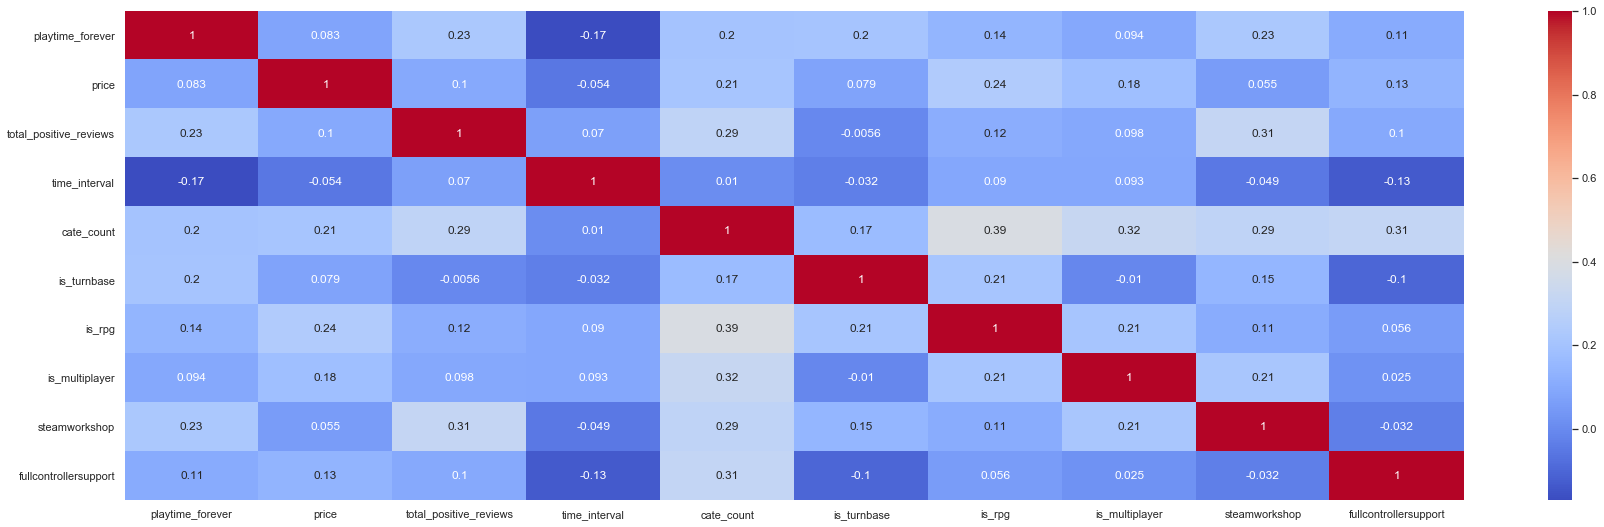

In [248]:
plot_heat_map(game_data.corr())

In [249]:
from sklearn import datasets, linear_model

from sklearn.decomposition import PCA


from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.metrics import mean_squared_error, make_scorer
import xgboost as xgb
import lightgbm as lgb

In [250]:
train_data = game_data[:train_len]
test_data = game_data[train_len:]

train_label = train_data['playtime_forever']
train_data = train_data.drop(columns=['playtime_forever'])
test_data.drop(columns=['playtime_forever'],inplace=True)


print('train_data shape: ', train_data.shape)
print('train_label shape: ', train_label.shape)
print('test_data shape : ', test_data.shape)

train_data shape:  (324, 9)
train_label shape:  (324,)
test_data shape :  (90, 9)


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [251]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data)
    rmse= np.sqrt(-cross_val_score(model, train_data, train_label, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [252]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_ridge = make_pipeline(RobustScaler(), Ridge(alpha=0.0001, fit_intercept=True, normalize=True))
#model_ridge = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=5)

In [260]:
lasso_score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(lasso_score.mean(), lasso_score.std()))

enet_score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(enet_score.mean(), enet_score.std()))

krr_score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(krr_score.mean(), krr_score.std()))

gboost_score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(gboost_score.mean(), gboost_score.std()))

randomtree_score = rmsle_cv(regr)
print("Random Tree score: {:.4f} ({:.4f})\n".format(randomtree_score.mean(), randomtree_score.std()))

xgb_score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(xgb_score.mean(), xgb_score.std()))


lgb_score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(lgb_score.mean(), lgb_score.std()))


ridge_score = rmsle_cv(model_ridge)
print("ridge score: {:.4f} ({:.4f})\n" .format(ridge_score.mean(), ridge_score.std()))




Lasso score: 7.2501 (2.1979)

ElasticNet score: 7.2499 (2.1980)



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189

Kernel Ridge score: 6.4445 (1.6082)

Gradient Boosting score: 6.5565 (2.9434)

Random Tree score: 9.1450 (3.9734)



/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost score: 6.5233 (1.8011)

LGBM score: 6.0162 (1.6841)

ridge score: 7.2504 (2.1974)



In [254]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [261]:
averaged_models = AveragingModels(models = (model_lgb, model_xgb, KRR))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))




/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getatt

 Averaged base models score: 5.7504 (1.6800)



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [262]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.2, random_state=42)



averaged_models.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
KRR.fit(X_train, y_train)

ave_pred = averaged_models.predict(X_val)
rid_pred = model_ridge.predict(X_val)
lgb_pred = model_lgb.predict(X_val)
krr_pred = KRR.predict(X_val)



print("LGB Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, lgb_pred)))
print("Average Model Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, ave_pred)))
print("Ridge Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, rid_pred)))
print("KRR Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, krr_pred)))

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


LGB Root Mean squared error:  5.634616455014496
Average Model Root Mean squared error:  5.438109034216827
Ridge Root Mean squared error:  7.6647891686332335
KRR Root Mean squared error:  5.6966396831333235


In [263]:
#model2.fit(X_train, y_train)
rid_test_pred = model_ridge.predict(test_data)

ave_test_pred = averaged_models.predict(test_data)

lgb_test_pred = model_lgb.predict(test_data)

krr_test_pred = KRR.predict(test_data)

In [264]:
def import_result(y_test_pred, filename):
    result_df = pd.DataFrame(y_test_pred, columns =['playtime_forever']) 
    result_df.index.name = 'id'
    result_df.to_csv(filename)

In [265]:
import_result(ave_test_pred, 'result.csv')